In [1]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

In [2]:
sammypath = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy'

In [3]:
%matplotlib widget

# ATARI Sammy Interface

This user example details basic use of the ATARI/SAMMY interface module. 
The example given here shows how to do individual sammy runs using the NV or IQ solution scheme.
The AutoFit example will detail sammy interface with YW scheme that can be used for automatic evaluations or simultaneous data fitting.

In [4]:
### setup the reaction model and sample a resonance
Ta_pair = Particle_Pair()      

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=8.79,
                       gn2_avg=465,
                       gn2_dof=1,
                       gg2_avg=350,
                       gg2_dof=1000)

# setup experimental transmission model
exp_model_T = Experimental_Model()


# calculate experimentally corrected transmission or capture yield with sammy
rto = sammy_classes.SammyRunTimeOptions(sammypath,
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": False,
                                         "sammy_runDIR": "sammy_runDIR_1"
                                         })

template_creator.make_input_template(
    'template_T.inp', Ta_pair, exp_model_T, rto)
exp_model_T.template = os.path.realpath('template_T.inp')



In [5]:
### Generate syndat from measurement models
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.syndat.control import Syndat_Model, syndatOPT


generative = Transmission_RPI()
reductive = Transmission_RPI()

synOPT = syndatOPT(calculate_covariance=True, explicit_covariance=True)

synT = Syndat_Model(
              exp_model_T,
              generative,
              reductive,
              synOPT)
## need to test syndat covariance generation with different tof ordering !!!

synT.sample(Ta_pair, 
            sammyRTO=rto,
            num_samples=1)

In [6]:
vars(generative.model_parameters)

{'trigo': (9758727, 0),
 'trigs': (18476117, 0),
 'm1': (1, 0.016),
 'm2': (1, 0.008),
 'm3': (1, 0.018),
 'm4': (1, 0.005),
 'ks': (0.563, 0.02402339737495515),
 'ko': (1.471, 0.05576763648617445),
 'b0s': (9.9, 0.1),
 'b0o': (13.4, 0.7),
 'a_b': ([582.7768594580712, 0.05149689096209191],
  [[1143.95753, 0.142659922], [0.142659922, 2.19135003e-05]]),
 'open_neutron_spectrum':                tof            bw     c         dc           E
 0    183110.960936  9.999999e-08  1132  33.645208  200.200037
 1    183010.960948  9.999998e-08  1221  34.942810  200.422933
 2    182910.960963  1.000001e-07  1171  34.219877  200.646202
 3    182810.960863  9.999996e-08  1221  34.942810  200.869845
 4    182710.960904  1.000001e-07  1108  33.286634  201.093861
 ..             ...           ...   ...        ...         ...
 184  164710.960895  9.999999e-08  1354  36.796739  248.453308
 185  164610.960907  9.999995e-08  1247  35.312887  248.761496
 186  164510.960956  1.000000e-07  1264  35.552778  24

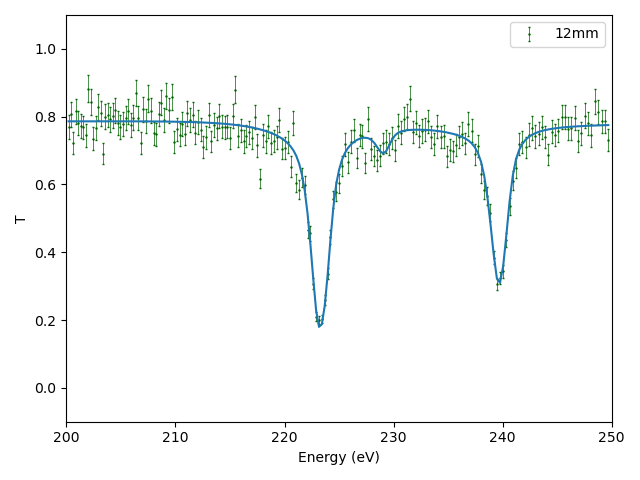

In [7]:
datasample = synT.samples[0]
data = datasample.pw_reduced


figure()
errorbar(data.E, data.exp, yerr=data.exp_unc, zorder=0,
                                        fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')
plot(data.E, data.true)
ylabel("T")

xlim([200,250])
ylim([-0.1,1.1])
legend()
xlabel('Energy (eV)')
tight_layout()

In [8]:
### Option to read in idc or you can just pass to sammy a filepath


# def read_idc(filepath):
#     data = {
#         'J': {},
#         'C': None,
#         'stat': None
#     }

#     with open(filepath, 'r') as f:
#         num_params = None
#         in_partial_derivatives = False
#         in_uncertainties = False
#         in_correlations = False
#         for line in f.readlines():
            
#             if line.lower().startswith("nu"):
#                 num_params = int(line.split()[-1])
            
#             elif line.lower().startswith("free-forma"):
#                 in_partial_derivatives = True

#             elif line.lower().startswith("uncertaint"):
#                 in_partial_derivatives = False
#                 in_uncertainties = True
            
#             elif line.lower().startswith("correlatio"):
#                 in_uncertainties = False
#                 in_correlations = True

#             elif in_partial_derivatives:
#                 splitline = line.split()
#                 E = float(splitline[0])
#                 stat_unc = float(splitline[1])
#                 derivatives = [float(x) for x in splitline[2:]]
#                 data['J'][E] = {'stat_unc': stat_unc, 'derivatives': derivatives}
                
#             elif in_uncertainties:
#                 uncertainties = [float(e) for e in line.split()]
#                 data['C'] = np.diag(uncertainties)

#             elif in_correlations:
#                 assert isinstance(num_params, int)
#                 correlations = []
#                 for _ in range(num_params):
#                     line = f.readline().strip().split()
#                     correlations.append([float(x) for x in line])

#     data['stat'] = None  # You need to fill in the logic for reading the 'stat' data

#     return data

# Usage
# filepath = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-1mm.idc'
# read_data = read_idc(filepath)

In [9]:
print(datasample.covariance_data.keys())

dict_keys(['CovT', 'diag_stat', 'Cov_sys', 'Jac_sys'])


In [10]:
datasample.covariance_data['CovT']

E,200.200037,200.422933,200.646202,200.869845,201.093861,201.318253,201.543020,201.768164,201.993685,202.219584,...,246.920925,247.226266,247.532173,247.838648,248.145693,248.453308,248.761496,249.070258,249.379595,249.689508
200.200037,0.001252,0.000369,0.000331,0.000373,0.000357,0.000354,0.000352,0.000341,0.000403,0.000386,...,0.000333,0.000343,0.000367,0.000357,0.000340,0.000387,0.000372,0.000359,0.000359,0.000334
200.422933,0.000369,0.001309,0.000346,0.000390,0.000374,0.000370,0.000368,0.000357,0.000422,0.000404,...,0.000348,0.000359,0.000384,0.000373,0.000356,0.000404,0.000389,0.000376,0.000376,0.000350
200.646202,0.000331,0.000346,0.001051,0.000350,0.000335,0.000331,0.000329,0.000320,0.000378,0.000362,...,0.000312,0.000322,0.000344,0.000334,0.000319,0.000362,0.000349,0.000337,0.000337,0.000313
200.869845,0.000373,0.000390,0.000350,0.001329,0.000378,0.000374,0.000372,0.000361,0.000427,0.000408,...,0.000352,0.000363,0.000388,0.000377,0.000360,0.000409,0.000393,0.000380,0.000380,0.000354
201.093861,0.000357,0.000374,0.000335,0.000378,0.001271,0.000358,0.000356,0.000345,0.000409,0.000391,...,0.000337,0.000348,0.000372,0.000361,0.000345,0.000392,0.000377,0.000364,0.000364,0.000339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248.453308,0.000387,0.000404,0.000362,0.000409,0.000392,0.000387,0.000385,0.000374,0.000442,0.000423,...,0.000364,0.000376,0.000402,0.000391,0.000373,0.001376,0.000408,0.000394,0.000394,0.000366
248.761496,0.000372,0.000389,0.000349,0.000393,0.000377,0.000373,0.000371,0.000360,0.000425,0.000407,...,0.000351,0.000362,0.000387,0.000376,0.000359,0.000408,0.001284,0.000379,0.000379,0.000353
249.070258,0.000359,0.000376,0.000337,0.000380,0.000364,0.000360,0.000358,0.000347,0.000411,0.000393,...,0.000339,0.000350,0.000374,0.000363,0.000347,0.000394,0.000379,0.001208,0.000366,0.000341
249.379595,0.000359,0.000376,0.000337,0.000380,0.000364,0.000360,0.000358,0.000347,0.000411,0.000393,...,0.000339,0.000350,0.000374,0.000363,0.000347,0.000394,0.000379,0.000366,0.001232,0.000341


In [11]:
# ### decomposed covariance test
# stat = copy(datasample.covariance_data["diag_stat"])
# CT = copy(datasample.covariance_data['CovT'])
# J = copy(datasample.covariance_data['Jac_sys'])
# C = copy(datasample.covariance_data['Cov_sys'])
# # C = np.diag(np.diag(C))
# test = J.T@C@J
# test.index.name = None
# assert(np.max(abs((np.diag(stat.var_stat) + test) - CT)) == 0.0)

# Fit the data with sammy

In [12]:
rto.bayes=True
rto.get_ECSCM = True
rto.ECSCM_rxn = 'transmission'

sammyINP = sammy_classes.SammyInputData(
    Ta_pair,
    Ta_pair.resonance_ladder,
    os.path.realpath('template_T.inp'),
    exp_model_T,
    # energy_grid=exp_model_T.energy_grid
    experimental_data=data,
    experimental_covariance = datasample.covariance_data
)

sammyINP.initial_parameter_uncertainty=10

# std = 0.01
# data.exp = np.random.default_rng().normal(data.true, std)
# data.exp_unc = std

sammyINP.experimental_data = data
sammyINP.resonance_ladder["varyE"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGg"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGn1"] = np.ones(len(Ta_pair.resonance_ladder))

sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
print(sammyOUT2.chi2_post)
print(sammyOUT2.chi2n_post)

331.368
1.75327


BACKGround functions
EXPON 0 0 582.77685 33.822441 0.0514968 0.0046811 

NORMALIZATION AND BACKGROUND ARE NEXT
1.0000000        0.0                                         3
0.0384200

!! when fitting background or normalization, the output lst has an additional column I need to be robust to.

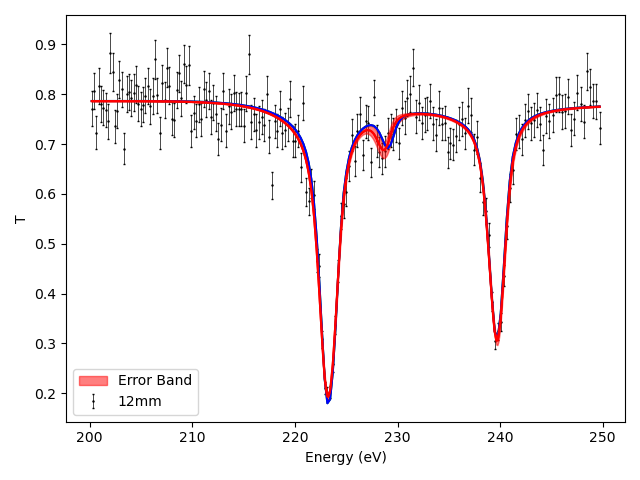

In [13]:

### Plot 
figure()

errorbar(data.E, data.exp, yerr=data.exp_unc, zorder=0,
                                        fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

plot(data.E, data.true, 'g')

plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_trans, 'b')
plot(sammyOUT2.pw_post.E, sammyOUT2.pw_post.theo_trans_bayes, 'r')

# plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_xs, 'b')
# plot(sammyOUT2.pw_post.E, sammyOUT2.pw_post.theo_xs_bayes, 'r')
# # plot(sammyOUT_old.est_df.E, sammyOUT_old.est_df.theo, 'b')
# # sammyOUT_old = copy(sammyOUT2)

x = sammyOUT2.est_df.E
y = sammyOUT2.est_df.theo
y_err=  sammyOUT2.est_df.theo_unc #
# y_err = np.sqrt(np.diag(sammyOUT2.ECSCM))
fill_between(x, y - y_err, y + y_err, color='r', alpha=0.5, label='Error Band')
plot(x, y, 'r')

ylabel("T")

# xlim([200,225])
# ylim([-0.1,1.1])
legend()

xlabel('Energy (eV)')
tight_layout()


# figure()
# imshow(sammyOUT2.ECSCM)
# colorbar()

In [14]:
ladder = copy(sammyOUT2.par_post)
print(ladder)
Ta_pair.spin_groups

            E          Gg       Gn1  varyE  varyGg  varyGn1  J_ID
0  223.222385  829.716208  8.112342    1.0     1.0      1.0   1.0
1  228.608646  834.866833  0.444974    1.0     1.0      1.0   1.0
2  239.647608  787.366558  5.318640    1.0     1.0      1.0   1.0


{3.0: {'Jpi': 3.0,
  'J_ID': 1,
  '<D>': 8.79,
  '<gn2>': 465,
  'n_dof': 1,
  '<gg2>': 350,
  'g_dof': 1000,
  'quantiles': {'D01': 0.9943384234177864,
   'D99': 21.284662911191237,
   'gn01': 0.07304585392801136,
   'gn99': 3085.2269194748646,
   'gg01': 314.61935642536463,
   'gg99': 387.43914802327606,
   'gt01': 314.69240227929265,
   'gt99': 3472.666067498141},
  'chs': 1,
  'Ls': [0]}}

In [15]:
from ATARI.utils.atario import expand_sammy_ladder_2_atari

expand_sammy_ladder_2_atari(Ta_pair, ladder)
ladder

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID,gg2,gn2,Jpi,L
0,223.222385,829.716208,8.112342,1.0,1.0,1.0,1.0,414.858104,152.911184,3.0,0.0
1,228.608646,834.866833,0.444974,1.0,1.0,1.0,1.0,417.433417,8.288007,3.0,0.0
2,239.647608,787.366558,5.318640,1.0,1.0,1.0,1.0,393.683279,96.755555,3.0,0.0


In [16]:
# samples = 100

# cov_true = np.zeros([len(sammyOUT2.pw),len(sammyOUT2.pw)])
# cov_est = np.zeros([len(sammyOUT2.est_df),len(sammyOUT2.est_df)])

# for i in range(samples):
#     # synT.run(sammyOUT.pw)
#     data.exp = np.random.default_rng().normal(synT.data.true, std)
#     data.exp_unc = std
#     sammyINP.experimental_data = synT.data
#     sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#     residual = np.atleast_2d(sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#     cov_true += residual.T@residual
#     cov_est += sammyOUT2.ECSCM
#     # true.append(cov_true)
#     # est.append(cov_est)

In [17]:
# iest = 0
# fig, axes = subplots(1,2, figsize=(10,4))
# # im1 = axes[0].imshow(np.log10(cov_true/(samples)))
# # im2 = axes[1].imshow(np.log10(cov_est/(samples-1)))
# im1 = axes[0].pcolormesh(cov_true/(samples), clim=(-1e-5, 8e-5))
# im2 = axes[1].pcolormesh(cov_est/(samples-1), clim=(-1e-5, 8e-5))
# axes[0].set_title("empirical")

# axes[1].set_title("estimated")
# # for ax in axes:
# colorbar(im1)

# colorbar(im2)

# print("Empirical Fnorm")
# print(np.linalg.norm(cov_true/(samples), ord='fro'))
# print("Estimated Fnorm")
# print(np.linalg.norm(cov_est/(samples-1), ord='fro'))

In [18]:
# ### Plot 
# figure()

# # errorbar(synT.data.E, synT.data.exp, yerr=synT.data.exp_unc, zorder=0,
# #                                         fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

# # plot(synT.data.E, synT.data.true, 'g')
# plot(synT.data.E, np.sqrt(np.diag(cov_true/samples)), label="empirical")
# plot(x, np.sqrt(np.diag(cov_est/(samples-1))), label="mean estimated")


# xlim([200,225])
# # ylim([-0.1,1.1])
# legend()

# xlabel('Energy (eV)')
# tight_layout()

In [19]:
# # result_dict = {}
# # stds = [0.1, 0.01, 0.001, 0.0001]
# stds = [0.00001, 0.05]

# for istd in stds:
#     samples = 1000
#     cov_true = np.zeros([len(sammyOUT2.pw), len(sammyOUT2.pw)])
#     cov_est = np.zeros([len(sammyOUT2.est_df), len(sammyOUT2.est_df)])
#     for i in range(samples):
#         # synT.run(sammyOUT.pw)
#         synT.data.exp = np.random.default_rng().normal(synT.data.true, istd)
#         synT.data.exp_unc = istd
#         sammyINP.experimental_data = synT.data
#         sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#         residual = np.atleast_2d(
#             sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#         cov_true += residual.T@residual
#         cov_est += sammyOUT2.ECSCM
        
#     result_dict[istd] = [cov_true, cov_est]

In [20]:
# stds = [1.0, 0.1, 0.05, 0.01, 0.001, 0.0001]
# true= []
# est = []

# for istd in stds:
#     res = result_dict[istd]
#     cov_true = res[0]
#     cov_est = res[1]
#     print(istd)
#     # print("Empirical Fnorm: ", np.linalg.norm(cov_true/(samples), ord='fro'))
#     # print("Estimated Fnorm: ", np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     # true.append(np.linalg.norm(cov_true/(samples), ord='fro'))
#     # est.append(np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     print("Empirical Fnorm: ", np.sum(np.diag(cov_true)**2/(samples)))
#     print("Estimated Fnorm: ", np.sum(np.diag(cov_est)**2/(samples-1)))
#     true.append(np.sum(np.diag(cov_true)**2/(samples)))
#     est.append(np.sum(np.diag(cov_est)**2/(samples-1)))

In [21]:
# figure()
# plot(stds, true, '.', label='Empirical')
# plot(stds, est, '.r', label='Estimate')
# xscale("log")
# yscale("log")
# legend()
# # ylabel("Noise Level")
# xlabel("Noise Level")